# CS675 Introduction to Data Science - Project #3

**Aayushi Verma**

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from prophet import Prophet
import datetime as dt

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Step One: Inspecting and Cleaning the Data

This dataset is obtained from: https://data.cityofnewyork.us/Housing-Development/Electric-Consumption-And-Cost-2010-Feb-2022-/jr24-e7cr. It details the monthly consumption and cost data by the 5 boroughs of New York.

In [2]:
df = pd.read_csv("data.csv")

/var/folders/n9/3mjn__fd1xd66lc1zh9nlj0h0000gp/T/ipykernel_23742/3477112522.py:1: DtypeWarning: Columns (17) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("data.csv")


In [3]:
df.head()

,Development Name,Borough,Account Name,Location,Meter AMR,Meter Scope,TDS #,EDP,RC Code,Funding Source,...,Meter Number,Estimated,Current Charges,Rate Class,Bill Analyzed,Consumption (KWH),KWH Charges,Consumption (KW),KW Charges,Other charges
0,ADAMS,BRONX,ADAMS,BLD 05,NONE,BLD 01 to 07,118.0,248,B011800,FEDERAL,...,7223256,N,15396.82,GOV/NYC/068,Yes,128800,7387.97,216.0,2808.0,5200.85
1,ADAMS,BRONX,ADAMS,BLD 05,NONE,BLD 01 to 07,118.0,248,B011800,FEDERAL,...,7223256,N,14556.34,GOV/NYC/068,Yes,115200,6607.87,224.0,2912.0,5036.47
2,ADAMS,BRONX,ADAMS,BLD 05,NONE,BLD 01 to 07,118.0,248,B011800,FEDERAL,...,7223256,N,13904.98,GOV/NYC/068,Yes,103200,5919.55,216.0,2808.0,5177.43
3,ADAMS,BRONX,ADAMS,BLD 05,NONE,BLD 01 to 07,118.0,248,B011800,FEDERAL,...,7223256,N,14764.04,GOV/NYC/068,Yes,105600,6057.22,208.0,2704.0,6002.82
4,ADAMS,BRONX,ADAMS,BLD 05,NONE,BLD 01 to 07,118.0,248,B011800,FEDERAL,...,7223256,N,13729.54,GOV/NYC/068,Yes,97600,5598.34,216.0,2808.0,5323.20


In [17]:
df.dtypes

Development Name              object
Borough                       object
Account Name                  object
Location                      object
Meter AMR                     object
Meter Scope                   object
TDS #                        float64
EDP                            int64
RC Code                       object
Funding Source                object
AMP #                         object
Vendor Name                   object
UMIS BILL ID                   int64
Revenue Month                 object
Service Start Date            object
Service End Date      datetime64[ns]
# days                       float64
Meter Number                  object
Estimated                     object
Current Charges              float64
Rate Class                    object
Bill Analyzed                 object
Consumption (KWH)              int64
KWH Charges                  float64
Consumption (KW)             float64
KW Charges                   float64
Other charges                float64
y

In [19]:
# obtaining list of all columns which we need to convert
cols_to_convert_to_int = df.columns[np.where(df.dtypes=="object")]
# cols_to_convert_to_int = cols_to_convert_to_int[1:] # we are excluding the customerID column
# converting each of the targeted columns to integer type
for col in cols_to_convert_to_int:
    try:
        df[col] = pd.to_numeric(df[col])
    except:
        pass


In [20]:
df.dtypes

Development Name              object
Borough                       object
Account Name                  object
Location                      object
Meter AMR                     object
Meter Scope                   object
TDS #                        float64
EDP                            int64
RC Code                       object
Funding Source                object
AMP #                         object
Vendor Name                   object
UMIS BILL ID                   int64
Revenue Month                 object
Service Start Date            object
Service End Date      datetime64[ns]
# days                       float64
Meter Number                  object
Estimated                     object
Current Charges              float64
Rate Class                    object
Bill Analyzed                 object
Consumption (KWH)              int64
KWH Charges                  float64
Consumption (KW)             float64
KW Charges                   float64
Other charges                float64
y

In [21]:
df['Service End Date'] = pd.to_datetime(df['Service End Date'])

In [22]:
df['year'] = df['Service End Date'].dt.year
df['month'] = df['Service End Date'].dt.month
df['day'] = df['Service End Date'].dt.day

### Averaging by Year

In [74]:
df_by_year = df.groupby('year',as_index=False).mean('Consumption (KW)')[['year','Consumption (KW)']]
df_by_year = df_by_year.rename(columns={'year':'ds','Consumption (KW)':'y'})
df_by_year['ds'] = pd.to_datetime(df_by_year['ds'],format='%Y')
df_by_year.head()

,ds,y
0,2010-01-01,86.332974
1,2011-01-01,0.000000
2,2012-01-01,71.050691
3,2013-01-01,66.071398
4,2014-01-01,62.291844


### Averaging by Month

In [85]:
df_by_month = df.groupby('month',as_index=False).mean('Consumption (KW)')[['month','Consumption (KW)']]
df_by_month = df_by_month.rename(columns={'month':'ds','Consumption (KW)':'y'})
df_by_month['ds'] = pd.to_datetime(df_by_month['ds'],format='%m').dt.month
df_by_month.head()

,ds,y
0,1,54.217259
1,2,66.186902
2,3,50.919868
3,4,50.037645
4,5,57.232956


### Averaging by Date

In [96]:
df_by_day = df[['Service End Date','Consumption (KW)']]
df_by_day = df_by_day.rename(columns={'Service End Date':'ds','Consumption (KW)':'y'})
df_by_day.head()

,ds,y
0,2010-01-26,216.0
1,2010-02-25,224.0
2,2010-03-26,216.0
3,2010-04-26,208.0
4,2010-05-24,216.0


## Step Two: Fitting Model

In [120]:
def future_preds(df,period):
    m = Prophet()
    m.fit(df)
    future = m.make_future_dataframe(period) #period is in units of days
    return (m, future)

### By Year

In [124]:
m_by_1_year, future_by_1_year = future_preds(df_by_year,period=2*365)
future_by_1_year.tail()

13:10:39 - cmdstanpy - INFO - Chain [1] start processing
13:10:39 - cmdstanpy - INFO - Chain [1] done processing


,ds
738,2023-12-28
739,2023-12-29
740,2023-12-30
741,2023-12-31
742,2024-01-01


In [125]:
forecast_for_1_year = m_by_1_year.predict(future_by_1_year)
forecast_for_1_year[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
738,2023-12-28,7.897310,-18.594625,32.345876
739,2023-12-29,21.617155,-5.294002,47.226363
740,2023-12-30,35.969219,12.111191,61.381547
741,2023-12-31,50.681616,25.115729,75.795818
742,2024-01-01,65.470366,41.325462,91.408128


In [131]:
forecast_for_1_year

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2010-01-01,2.212750,32.218581,81.569190,2.212750,2.212750,56.168248,56.168248,56.168248,56.168248,56.168248,56.168248,0.0,0.0,0.0,58.380998
1,2011-01-01,3.242182,32.173455,81.156650,3.242182,3.242182,52.511609,52.511609,52.511609,52.511609,52.511609,52.511609,0.0,0.0,0.0,55.753791
2,2012-01-01,4.271615,28.841538,78.123911,4.271615,4.271615,48.837102,48.837102,48.837102,48.837102,48.837102,48.837102,0.0,0.0,0.0,53.108716
3,2013-01-01,5.303867,39.816431,91.945031,5.303867,5.303867,59.802492,59.802492,59.802492,59.802492,59.802492,59.802492,0.0,0.0,0.0,65.106360
4,2014-01-01,6.333300,36.168648,87.440279,6.333300,6.333300,56.168248,56.168248,56.168248,56.168248,56.168248,56.168248,0.0,0.0,0.0,62.501548
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
738,2023-12-28,16.621982,-18.594625,32.345876,16.621982,16.621982,-8.724672,-8.724672,-8.724672,-8.724672,-8.724672,-8.724672,0.0,0.0,0.0,7.897310
739,2023-12-29,16.624803,-5.294002,47.226363,16.624802,16.624803,4.992352,4.992352,4.992352,4.992352,4.992352,4.992352,0.0,0.0,0.0,21.617155
740,2023-12-30,16.627623,12.111191,61.381547,16.627623,16.627623,19.341596,19.341596,19.341596,19.341596,19.341596,19.341596,0.0,0.0,0.0,35.969219
741,2023-12-31,16.630443,25.115729,75.795818,16.630443,16.630444,34.051173,34.051173,34.051173,34.051173,34.051173,34.051173,0.0,0.0,0.0,50.681616


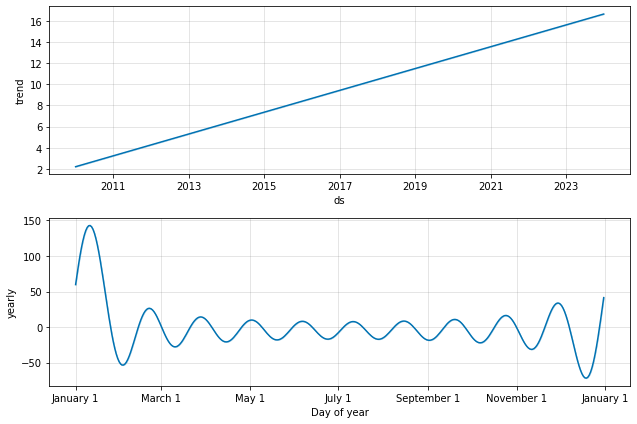

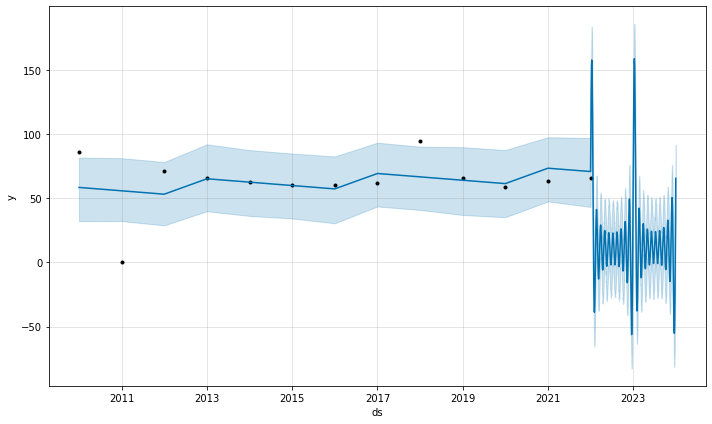

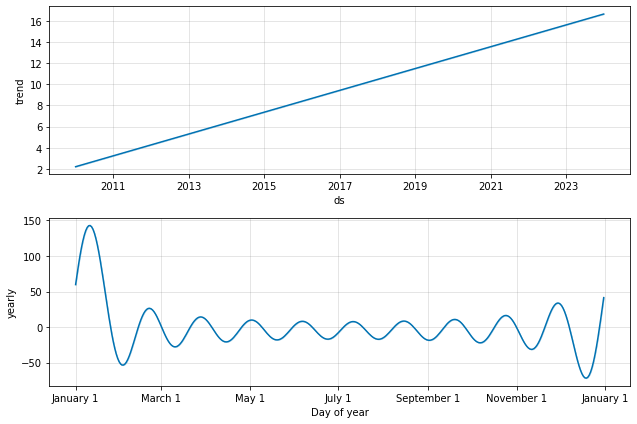

In [130]:
m_by_1_year.plot(forecast_for_1_year)
m_by_1_year.plot_components(forecast_for_1_year)

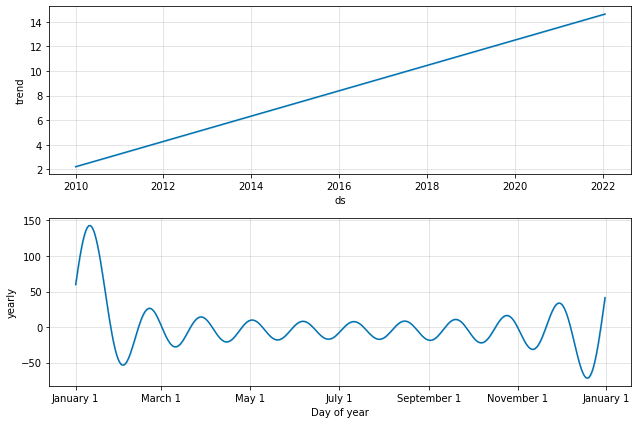

In [127]:
fig2 = m_by_1_year.plot_components(forecast)

In [16]:
from dask.distributed import Client



client = Client()  # connect to the cluster

df_cv = cross_validation(m, initial='730 days', period='180 days', horizon='365 days',

                         parallel="dask")

ModuleNotFoundError: No module named 'dask'

In [ ]:
# from prophet.plot import plot_plotly, plot_components_plotly

# plot_plotly(m, forecast)

In [ ]:
# plot_components_plotly(m, forecast)
